In [7]:
!pip install ipython-sql

In [8]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [9]:
!pip install ipython-sql psycopg2-binary

In [10]:
from sqlalchemy import create_engine
dbname="OLIST"
user="postgres"
password="4610"
host="localhost"
port="5432"

# Crear motor de conexión
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}")


In [11]:
import pandas as pd 

# ANALISIS DE CLIENTE

In [19]:
# Cantidad de clientes que tiene OLIST por estado
query = """
SELECT customer_state,
       COUNT(customer_unique_id) AS no_of_customers
FROM customers
GROUP BY customer_state
ORDER BY no_of_customers DESC;
"""

# Ejecutar consulta
df = pd.read_sql_query(query, engine)

# Mostrar los resultados
print(df)

   customer_state  no_of_customers
0              SP            41746
1              RJ            12852
2              MG            11635
3              RS             5466
4              PR             5045
5              SC             3637
6              BA             3380
7              DF             2140
8              ES             2033
9              GO             2020
10             PE             1652
11             CE             1336
12             PA              975
13             MT              907
14             MA              747
15             MS              715
16             PB              536
17             PI              495
18             RN              485
19             AL              413
20             SE              350
21             TO              280
22             RO              253
23             AM              148
24             AC               81
25             AP               68
26             RR               46


In [25]:
#Top 10 Productos mas ordenados por los clientes

query = """
WITH customer_items AS (
    SELECT *
    FROM customers
    JOIN orders USING(customer_id)
    JOIN order_items USING(order_id)
    JOIN products USING(product_id)
)
SELECT product_category,
       SUM(order_item_id) AS units
FROM customer_items
GROUP BY product_category
ORDER BY units DESC
LIMIT 10;
"""

# Ejecutar consulta y guardar en DataFrame
df = pd.read_sql_query(query, engine)

# Mostrar resultados
print(df)

         product_category  units
0         cama_mesa_banho  13665
1        moveis_decoracao  11540
2            beleza_saude  11081
3           esporte_lazer   9932
4  informatica_acessorios   9874
5   utilidades_domesticas   9051
6      relogios_presentes   6594
7      ferramentas_jardim   5874
8               telefonia   5161
9              automotivo   4881


In [26]:
# Precio promedio de pedido por estado
query =  '''
WITH order_price AS(
    SELECT customer_id,
           customer_state,
           (order_item_id * price + freight_value)::real AS total_price
    FROM customers
    JOIN orders USING(customer_id)
    JOIN order_items USING(order_id)
    JOIN products USING(product_id)
)
SELECT customer_state,
       AVG(total_price)::real AS avg_price
FROM order_price
GROUP BY customer_state
ORDER BY avg_price DESC;
'''

# Ejecutar consulta y guardar en DataFrame
df_precio_promedio = pd.read_sql_query(query, engine)

# Mostrar resultados
print(df_precio_promedio)

   customer_state  avg_price
0              PB  254.92203
1              AC  235.44011
2              AL  230.23581
3              AP  224.04231
4              PI  219.86848
5              RO  216.66422
6              PA  216.15749
7              RR  210.93135
8              TO  207.69473
9              CE  206.16673
10             SE  205.05421
11             MT  203.74744
12             RN  202.12102
13             MA  198.72446
14             PE  188.99063
15             AM  183.80533
16             MS  180.05310
17             BA  179.83725
18             GO  178.20496
19             RJ  164.28613
20             SC  162.26056
21             DF  160.20909
22             ES  159.08660
23             RS  158.83072
24             PR  157.74991
25             MG  155.78080
26             SP  139.50151


In [27]:
# Métodos de pago por cliente
query = '''
SELECT payment_type,
       COUNT(DISTINCT customer_id) AS cantidad_clientes
FROM orders AS o
JOIN order_payments AS p USING(order_id)
JOIN customers AS c USING(customer_id)
GROUP BY payment_type
ORDER BY cantidad_clientes DESC;
'''

# Ejecutar consulta y guardar en DataFrame
df = pd.read_sql_query(query, engine)

# Mostrar resultados
print(df)

  payment_type  cantidad_clientes
0  credit_card              76505
1       boleto              19784
2      voucher               3866
3   debit_card               1528
4  not_defined                  3


# ANALISIS DE PRODUCTO Y VENDORES

In [20]:
# Este análisis nos muestra la diferencia promedio (en días) entre la fecha estimada
# de entrega y la fecha real de entrega, agrupado por mes de compra.
query = """
SELECT month,
       AVG(deviation_from_estimated)::real AS difference
FROM (
    SELECT EXTRACT(MONTH FROM order_purchase)::int AS month,
           EXTRACT('days' FROM order_estimated_delivery - order_delivered_customer)::int AS deviation_from_estimated
    FROM orders
    WHERE order_status = 'delivered'
) AS diff
GROUP BY month
ORDER BY month;
"""

# Ejecutar consulta
df = pd.read_sql_query(query, engine)

# Mostrar los resultados
print(df)

    month  difference
0       1   13.384960
1       2    9.620979
2       3    7.172164
3       4   11.974069
4       5   11.707500
5       6   16.024807
6       7   10.879737
7       8    9.200588
8       9   10.389063
9      10   12.356947
10     11    7.266603
11     12   12.093943


In [21]:
# Este análisis nos muestra el tiempo promedio de entrega (en días)
# desde la fecha de compra hasta la fecha de entrega,
# agrupado por estado del cliente.

query = """
SELECT delivery_time.customer_state,
       AVG(delivery_time.delivery_in_days)::real AS avg_delivery_time_days
FROM (
    SELECT cu.customer_state,
           EXTRACT('days' FROM od.order_delivered_customer - od.order_purchase)::int AS delivery_in_days
    FROM orders AS od
    JOIN customers AS cu ON od.customer_id = cu.customer_id
    WHERE order_status = 'delivered'
) AS delivery_time
GROUP BY customer_state
ORDER BY avg_delivery_time_days DESC;
"""

# Ejecutar consulta
df = pd.read_sql_query(query, engine)

# Mostrar los resultados
print(df)

   customer_state  avg_delivery_time_days
0              RR               28.975609
1              AP               26.731344
2              AM               25.986206
3              AL               24.040302
4              PA               23.316067
5              MA               21.117155
6              SE               21.029850
7              CE               20.817827
8              AC               20.637500
9              PB               19.953579
10             PI               18.993698
11             RO               18.913580
12             BA               18.866400
13             RN               18.824894
14             PE               17.965473
15             MT               17.593680
16             TO               17.226278
17             ES               15.331830
18             MS               15.191155
19             GO               15.150741
20             RJ               14.848583
21             RS               14.819237
22             SC               14

In [22]:
# Este análisis nos muestra el producto más vendido en cada estado,
# tomando en cuenta únicamente las órdenes entregadas.
query = """
WITH sales AS (
    SELECT cu.customer_state,
           pr.product_category,
           COUNT(oi.product_id) AS total_sold
    FROM customers AS cu
    JOIN orders AS o ON cu.customer_id = o.customer_id
    JOIN order_items AS oi ON o.order_id = oi.order_id
    JOIN products AS pr ON oi.product_id = pr.product_id
    WHERE o.order_status = 'delivered'
    GROUP BY cu.customer_state, pr.product_category
)
SELECT customer_state, product_category, total_sold
FROM (
    SELECT customer_state,
           product_category,
           total_sold,
           ROW_NUMBER() OVER (PARTITION BY customer_state ORDER BY total_sold DESC) AS rank
    FROM sales
) ranked
WHERE rank = 1
ORDER BY total_sold DESC;
"""


# Ejecutar consulta
df = pd.read_sql_query(query, engine)

# Mostrar resultados
print(df)

   customer_state  product_category  total_sold
0              SP   cama_mesa_banho        5157
1              RJ   cama_mesa_banho        1605
2              MG   cama_mesa_banho        1322
3              RS   cama_mesa_banho         611
4              PR  moveis_decoracao         516
5              SC     esporte_lazer         356
6              BA      beleza_saude         340
7              DF      beleza_saude         242
8              PE      beleza_saude         233
9              GO   cama_mesa_banho         231
10             ES   cama_mesa_banho         223
11             CE      beleza_saude         162
12             PA      beleza_saude         105
13             MT      beleza_saude          89
14             MA      beleza_saude          88
15             PB      beleza_saude          76
16             MS     esporte_lazer          74
17             AL      beleza_saude          62
18             RN      beleza_saude          57
19             PI      beleza_saude     

In [23]:
# Este análisis muestra los 5 vendedores con más ventas en cada uno
# de los 3 estados principales (mercados más grandes).
query = """
WITH market_size AS (
    SELECT cu.customer_state,
           COUNT(o.order_id) AS total_orders
    FROM customers AS cu
    JOIN orders AS o ON cu.customer_id = o.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY cu.customer_state
    ORDER BY total_orders DESC
    LIMIT 3
),
seller_sales AS (
    SELECT cu.customer_state,
           oi.seller_id,
           COUNT(oi.order_id) AS total_sales
    FROM customers AS cu
    JOIN orders AS o ON cu.customer_id = o.customer_id
    JOIN order_items AS oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY cu.customer_state, oi.seller_id
)
SELECT customer_state, seller_id, total_sales
FROM (
    SELECT ss.customer_state,
           ss.seller_id,
           ss.total_sales,
           ROW_NUMBER() OVER (PARTITION BY ss.customer_state ORDER BY ss.total_sales DESC) AS rank
    FROM seller_sales ss
    JOIN market_size ms ON ss.customer_state = ms.customer_state
) ranked
WHERE rank <= 5
ORDER BY customer_state, total_sales DESC;
"""

# Ejecutar consulta
df = pd.read_sql_query(query, engine)

# Mostrar resultados
print(df)

   customer_state                         seller_id  total_sales
0              MG  1f50f920176fa81dab994f9023523100          256
1              MG  4a3ca9315b744ce9f8e9374361493884          251
2              MG  6560211a19b47992c3666cc44a7e94c0          213
3              MG  a1043bafd471dff536d0c462352beb48          200
4              MG  1025f0e2d44d7041d6cf58b6550e0bfa          199
5              RJ  4a3ca9315b744ce9f8e9374361493884          292
6              RJ  1f50f920176fa81dab994f9023523100          282
7              RJ  7c67e1448b00f6e969d365cea6b010ab          260
8              RJ  4869f7a5dfa277a7dca6462dcf3b52b2          207
9              RJ  6560211a19b47992c3666cc44a7e94c0          206
10             SP  6560211a19b47992c3666cc44a7e94c0          880
11             SP  4a3ca9315b744ce9f8e9374361493884          878
12             SP  da8622b14eb17ae2831f4ac5b9dab84a          831
13             SP  955fee9216a65b617aa5c0531780ce60          729
14             SP  1f50f9

In [30]:
query = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
ORDER BY table_schema, table_name;
"""

df = pd.read_sql_query(query, engine)
print(df)

  table_schema           table_name
0       public            customers
1       public         geo_location
2       public          order_items
3       public       order_payments
4       public        order_reviews
5       public               orders
6       public  product_translation
7       public             products
8       public              sellers


In [33]:
query = """
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'orders';
"""
df_cols = pd.read_sql_query(query, engine)
print(df_cols)

                column_name
0  order_estimated_delivery
1            order_approved
2   order_delivered_carrier
3  order_delivered_customer
4            order_purchase
5               customer_id
6              order_status
7                  order_id


In [34]:
query = """
SELECT DATE(order_purchase) AS date,
       COUNT(*) AS orders
FROM orders
WHERE order_status = 'delivered'
GROUP BY DATE(order_purchase)
ORDER BY date;
"""
df = pd.read_sql_query(query, engine, parse_dates=["date"])
print(df.head())

        date  orders
0 2016-09-15       1
1 2016-10-03       7
2 2016-10-04      54
3 2016-10-05      35
4 2016-10-06      41


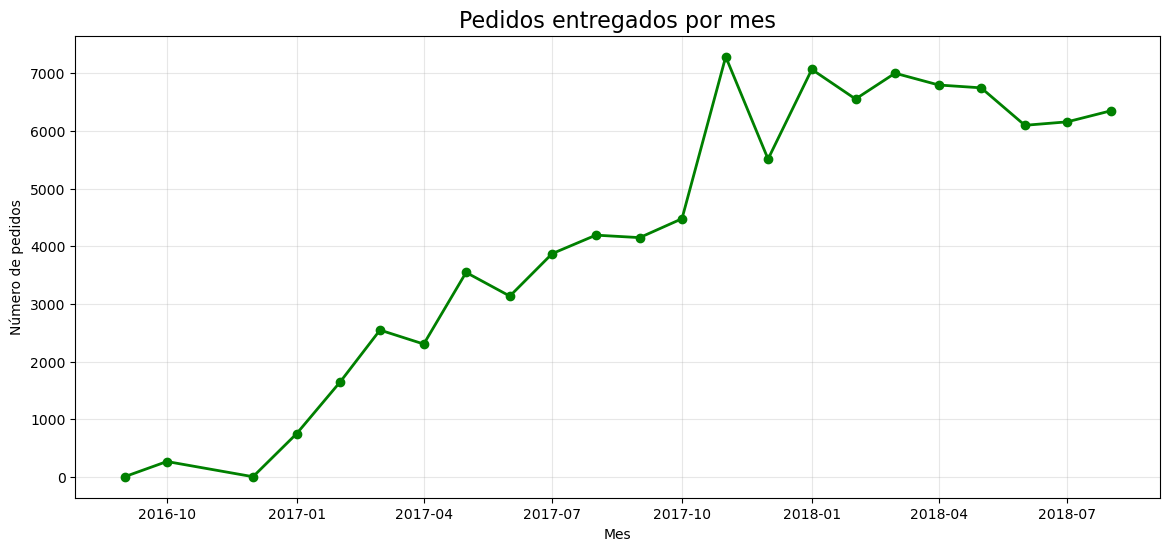

In [35]:
query = """
SELECT DATE_TRUNC('month', order_purchase)::date AS month,
       COUNT(*) AS orders
FROM orders
WHERE order_status = 'delivered'
GROUP BY DATE_TRUNC('month', order_purchase)
ORDER BY month;
"""
df_monthly = pd.read_sql_query(query, engine, parse_dates=["month"])

plt.figure(figsize=(14,6))
plt.plot(df_monthly["month"], df_monthly["orders"], marker="o", color="green", linewidth=2)
plt.title("Pedidos entregados por mes", fontsize=16)
plt.xlabel("Mes")
plt.ylabel("Número de pedidos")
plt.grid(alpha=0.3)
plt.show()